In [105]:
import pandas as pd
import numpy as np
import random 
import datetime
stockdata = pd.read_excel('E:/study_business/grad/2005-2020_week.xlsx',index_col=0)
np.random.seed(1100)
choosestock = np.random.randint(0,len(stockdata.columns),7).tolist()
start = datetime.datetime(2013,1,1)
hisstart = datetime.datetime(2010,1,1)
hisdata = stockdata.iloc[stockdata.index >= hisstart, choosestock]
curdata = stockdata.iloc[stockdata.index >= start, choosestock]
rt = (curdata.pct_change()+1).dropna().apply(np.log)
hisrt = hisdata.pct_change(periods = 150)
hisrt = hisrt[hisrt.index >= start]/150

In [106]:
def choosearm(p):
    np.random.seed(1111)
    q = np.random.random(1)
    n = sum(q>np.cumsum(p))
    return n

In [107]:
# def Hedge Algorithm (FULL FEEDBACK AND ADVERSARIAL COSTS)

def hedge_alg(obj, epsilon, T=True):
    if T == True:
        T1 = len(obj)
    else: T1 == T
    res1 = pd.DataFrame(columns = obj.columns,index = obj.index)
    # intialize parameters
    num_arms = len(obj.columns)
    cost = np.zeros(num_arms)
    w1 = np.ones(num_arms) 

    # loop for hedge algorithm
    for t in range(0,T1-1):
        pt = w1/sum(w1)
        n = choosearm(pt)
        cost[n] = -obj.iloc[t,n]
        w1 = w1*(1-epsilon)**cost
        res1.iloc[t+1,n] = obj.iloc[t+1,n]
        # return (np.argmax(w1),w1[np.argmax(w1)])
    return res1
hed_res = hedge_alg(rt, 0.2, T=True)
hed = (np.e**pd.DataFrame(hed_res.stack(),columns=['hedge_return'])).cumprod().reset_index().set_index('level_0')

In [108]:
# epsilon-greedy algorithm
def changearm(arms,cur_arm):
    if type(arms) != list:
        arms = arms.tolist()
    arms_copy = arms.copy()
    del arms_copy[cur_arm]
    import random
    random.seed(1234)
    new_arm_name = random.choice(arms_copy)
    new_arm = arms.index(new_arm_name)
    return new_arm


def epsilon_greedy(obj,T = True):
    if T == True:
        T1 = len(obj)
    else: T1 == T
    df = pd.DataFrame(columns=obj.columns,index = obj.index)
    num_arms = len(obj.columns)
    arm = 0
    df.iloc[0,arm] =  obj.iloc[0,arm]
    for t in range(1,T1):
        # epsilon = t**(-1/3)*(num_arms*np.log(t))**(1/3)
        epsilon = 0.2
        np.random.seed(1234)
        suc = np.random.random(1)
        if suc <= epsilon:
            arm = changearm(obj.columns,cur_arm = arm)
            df.iloc[t,arm] =  obj.iloc[t,arm]
        else:
            arm = np.argmax(df.mean())
            df.iloc[t,arm] =  obj.iloc[t,arm]
    return df
eps_res = epsilon_greedy(rt, T=True)
eps = (np.e**pd.DataFrame(eps_res.stack(),columns=['epsilon_greedy_return'])).cumprod().reset_index().set_index('level_0')

In [109]:
def UCB1(obj,T = True):
    if T == True:
        T1 = len(obj)
    else: T1 == T
    df = pd.DataFrame(columns=obj.columns,index = obj.index)
    df.iloc[0,:] =  obj.iloc[0,:]
    for t in range(1,T1):
        arm = np.argmax(df.mean()+np.sqrt(2*np.log(t)/df.count()))
        df.iloc[t,arm] =  obj.iloc[t,arm]
    return df

ucb_res = UCB1(rt, T=True)
ucb = (np.e**pd.DataFrame(ucb_res.stack(),columns=['ucb1_return'])).cumprod().reset_index().set_index('level_0')

In [110]:
# Mean average
hisrt_mean = hisdata.pct_change(periods = 8)
hisrt_mean = hisrt_mean[hisrt_mean.index >= start]/8

def meanave(obj):
    df = pd.DataFrame(0,columns=obj.columns,index = obj.index)
    for i in range(len(obj)-1):
        df.iloc[i+1,np.argmax(hisrt_mean.iloc[i,:])] = -1
        df.iloc[i+1,np.argmin(hisrt_mean.iloc[i,:])] = 1
    res = df*obj
    res['mean_average_return'] = res.sum(axis = 1)
    return res['mean_average_return']

mea_res = meanave(rt)
mea = (np.e**pd.DataFrame(mea_res,columns=['mean_average_return'])).cumprod()

In [111]:
# ES optimal algorithm
def F(u,alpha,t,delta,gamma,obj):
    UH = 0
    UR = 0
    for s in range(t):
        UH = max(-(sum(u*np.array(obj.iloc[s]))+UH+alpha),0)+UH
        UR = max(-(sum(u*np.array(obj.iloc[s]))+alpha),0)+UR
    Fgamma = alpha + 1/((delta+t-1)*(1-gamma)) * (UH+UR)
    return Fgamma

# solve optimal weight

def portfolio_selection(obj,obj_history, epsilon, T, lamb, gamma=0.95):
    w_data = pd.DataFrame(columns=rt.columns, index = rt.index)
    res1 = pd.DataFrame(columns=['stock'],index = rt.index)
    # intialize parameters
    num_arms = len(obj.columns)
    cost = np.zeros(num_arms)
    w1 = np.ones(num_arms) 
    epsilon=np.sqrt(np.log(num_arms)/T)

    from scipy import optimize
    # loop for hedge algorithm
    for t in range(0,T-1):
        pt = w1/sum(w1)
        n = choosearm(pt)

        def F(u):
            delta = t
            UH = 0
            UR = 0
            alpha = u[num_arms]
            for s in range(t):
                U1 = sum([u[i]*obj_history.iloc[s,i] for i in range(num_arms)])
                U2 = sum([u[i]*obj.iloc[s,i] for i in range(num_arms)])
                # U = obj_C.iloc[s,num_arms-2] - sum([u[i]*(obj_C.iloc[s,i]-obj_C.iloc[s,num_arms-2]) for i in range(num_arms-2)])
                UH = max(-(U1+alpha),0)+UH
                UR = max(-(U2+alpha),0)+UR
            Fgamma = alpha + 1/((delta+t-1)*(1-gamma)) * (UH+UR)
            return Fgamma
        def cons(u):
            return sum([u[i] for i in range(len(u)-1)]) - 1
        def ieq_cons(u):
            for i in range(len(u)-1):
                return u[i]
        print(t)
        from scipy.optimize import Bounds
        w_c = optimize.fmin_slsqp(F,[1/num_arms]*(num_arms)+[0],eqcons=[cons,],ieqcons=[ieq_cons,])[:-1]

        cost[n] = 1/(1+np.exp(-obj.iloc[t,n]))
        w1 = w1*(1-epsilon)**cost
        res1.iloc[t+1,0] = stockdata.columns[np.argmax(w1)]
        w_star = lamb
        w = (w_c*(1-lamb)).tolist()
        w[np.argmax(w1)] = w[np.argmax(w1)]+w_star
        w_data.iloc[t+1] = w
        # return (np.argmax(w1),w1[np.argmax(w1)])
    # res = w_data.merge(res1)
    return res1, w_data

res1, w_data = portfolio_selection(rt,hisrt, 0.05, len(rt.index), 0.5, gamma=0.95)

0
Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: -7.105427357600986e+30
            Iterations: 46
            Function evaluations: 414
            Gradient evaluations: 46
1
Iteration limit reached    (Exit mode 9)
            Current function value: -1.9171255034960594e+18
            Iterations: 100
            Function evaluations: 1054
            Gradient evaluations: 100
2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00018849932518637892
            Iterations: 19
            Function evaluations: 234
            Gradient evaluations: 19
3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006714821677776753
            Iterations: 19
            Function evaluations: 257
            Gradient evaluations: 19
4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00010693083143730082
            Iterations: 23
 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.033442674603227654
            Iterations: 43
            Function evaluations: 437
            Gradient evaluations: 43
40
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03379358910163071
            Iterations: 30
            Function evaluations: 304
            Gradient evaluations: 30
41
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04704674584557696
            Iterations: 21
            Function evaluations: 227
            Gradient evaluations: 21
42
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04702290041129752
            Iterations: 20
            Function evaluations: 215
            Gradient evaluations: 20
43
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04692095578366725
            Iterations: 26
  

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04860521527336939
            Iterations: 21
            Function evaluations: 214
            Gradient evaluations: 21
79
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04842933369190486
            Iterations: 25
            Function evaluations: 250
            Gradient evaluations: 25
80
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04831284374363609
            Iterations: 35
            Function evaluations: 347
            Gradient evaluations: 35
81
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04819647253273185
            Iterations: 18
            Function evaluations: 195
            Gradient evaluations: 18
82
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04799272470412753
            Iterations: 29
   

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04423576583128222
            Iterations: 24
            Function evaluations: 247
            Gradient evaluations: 24
117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.044141011661570626
            Iterations: 24
            Function evaluations: 242
            Gradient evaluations: 24
118
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04407413033817535
            Iterations: 27
            Function evaluations: 274
            Gradient evaluations: 27
119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.043987319654836286
            Iterations: 28
            Function evaluations: 286
            Gradient evaluations: 28
120
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04387726922510671
            Iterations: 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06874968390468159
            Iterations: 14
            Function evaluations: 143
            Gradient evaluations: 14
155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06843289060809071
            Iterations: 19
            Function evaluations: 197
            Gradient evaluations: 19
156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07706338405253892
            Iterations: 35
            Function evaluations: 354
            Gradient evaluations: 35
157
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0831043644597622
            Iterations: 20
            Function evaluations: 199
            Gradient evaluations: 20
158
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08283462865024527
            Iterations: 27


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07932208486749462
            Iterations: 33
            Function evaluations: 318
            Gradient evaluations: 33
193
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0792105137728022
            Iterations: 24
            Function evaluations: 238
            Gradient evaluations: 24
194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07904988673036836
            Iterations: 21
            Function evaluations: 206
            Gradient evaluations: 21
195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07887481720353275
            Iterations: 21
            Function evaluations: 209
            Gradient evaluations: 21
196
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07867234012274017
            Iterations: 25


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07658596471225443
            Iterations: 23
            Function evaluations: 225
            Gradient evaluations: 23
231
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07645400266986989
            Iterations: 25
            Function evaluations: 245
            Gradient evaluations: 25
232
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07633376103890352
            Iterations: 24
            Function evaluations: 233
            Gradient evaluations: 24
233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07623621365556828
            Iterations: 23
            Function evaluations: 224
            Gradient evaluations: 23
234
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07611336365634067
            Iterations: 25

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0783644714245568
            Iterations: 24
            Function evaluations: 238
            Gradient evaluations: 24
269
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07824878555378914
            Iterations: 23
            Function evaluations: 231
            Gradient evaluations: 23
270
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07814640877453415
            Iterations: 20
            Function evaluations: 197
            Gradient evaluations: 20
271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07804455447553693
            Iterations: 20
            Function evaluations: 204
            Gradient evaluations: 20
272
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07870133880995353
            Iterations: 24


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07749846252922948
            Iterations: 23
            Function evaluations: 227
            Gradient evaluations: 23
307
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07741347762277695
            Iterations: 18
            Function evaluations: 182
            Gradient evaluations: 18
308
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07732416771050828
            Iterations: 23
            Function evaluations: 227
            Gradient evaluations: 23
309
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.077243125005278
            Iterations: 18
            Function evaluations: 182
            Gradient evaluations: 18
310
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0771503884915818
            Iterations: 14
  

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07625182242200118
            Iterations: 21
            Function evaluations: 205
            Gradient evaluations: 21
345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07621827684401286
            Iterations: 13
            Function evaluations: 130
            Gradient evaluations: 13
346
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07613234137614636
            Iterations: 15
            Function evaluations: 155
            Gradient evaluations: 15
347
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07602086189350467
            Iterations: 22
            Function evaluations: 217
            Gradient evaluations: 22
348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07597728716829591
            Iterations: 15

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07577789100047831
            Iterations: 25
            Function evaluations: 242
            Gradient evaluations: 25
383
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07571004739503319
            Iterations: 26
            Function evaluations: 250
            Gradient evaluations: 26
384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0756512078948063
            Iterations: 19
            Function evaluations: 185
            Gradient evaluations: 19
385
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07557785858026914
            Iterations: 23
            Function evaluations: 227
            Gradient evaluations: 23
386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07551835909547927
            Iterations: 18


In [112]:
res = res1.merge(w_data,left_index=True,right_index=True)

pandl = w_data*rt

pandl['totalreturn'] = pandl.apply(lambda x: sum(x),axis = 1)

pandl = pandl[abs(pandl['totalreturn'])<3]

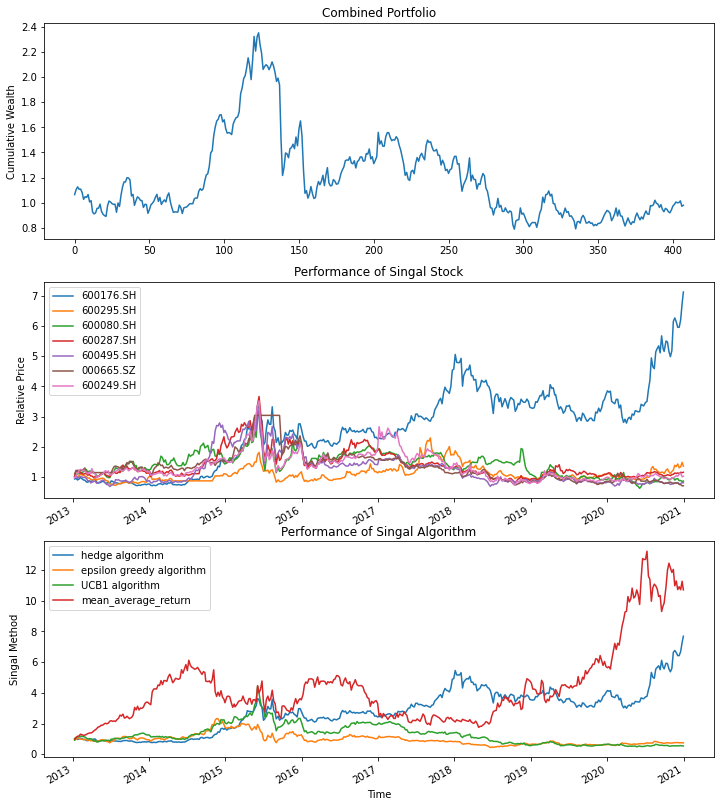

In [113]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(3,1,figsize=(12,15))
ax[0].plot(np.cumprod(np.array(np.e**pandl['totalreturn'])))
ax[0].set_title('Combined Portfolio')
ax[0].set_ylabel('Cumulative Wealth')

(np.e**rt).cumprod().plot(ax = ax[1])
ax[1].legend(loc='best')
ax[1].set_ylabel('Relative Price')
ax[1].set_title('Performance of Singal Stock')

hed['hedge_return'].plot(ax = ax[2],label = 'hedge algorithm')
eps['epsilon_greedy_return'].plot(ax = ax[2],label = 'epsilon greedy algorithm')
ucb['ucb1_return'].plot(ax = ax[2],label = 'UCB1 algorithm')
mea.plot(ax = ax[2],label = 'Mean Average')
ax[2].legend(loc='best')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Singal Method')
ax[2].set_title('Performance of Singal Algorithm')
for tick in ax[2].get_xticklabels():
    tick.set_rotation(30) 
plt.show()

In [114]:
# report 

def report(ret, indexset,f):##this is for summarising investment results
    investresult_test = pd.DataFrame(index=[indexset],columns=['return','std','sharpe'])
    total_value = ret
    # daily_return = (total_value - total_value.shift(1))/total_value.shift(1)
    mean = total_value.mean()*f
    std = total_value.std()*np.sqrt(f)
    sharpe = mean/(std)
    # maxdrawdown = MaxDrawdown(ret.iloc[:,0].tolist())
    # turnover1 = turnoverfuc(ret)
    investresult_test.loc[indexset,'return'] = mean
    investresult_test.loc[indexset,'std'] = std
    investresult_test.loc[indexset,'sharpe'] = sharpe
    # investresult_test.loc[indexset,'maxdrawdown'] = maxdrawdown
    # investresult_test.loc[indexset,'turnover'] = turnover1
    return investresult_test

In [115]:
investresult = pd.concat([
    report(hed_res.stack(),'Hedge',52),
    report(eps_res.stack(),'EpsilonGreedy',52), 
    report(ucb_res.stack(),'UCB1',52), 
    report(mea_res,'MeanAverage',52), 
    report(pandl['totalreturn'],'Combined',52)], 
    ignore_index=False)

print(investresult)

                 return       std    sharpe
Hedge          0.259332  0.410174  0.632249
EpsilonGreedy -0.038247   0.45753 -0.083593
UCB1          -0.076973  0.423672 -0.181679
MeanAverage    0.300741  0.557806  0.539149
Combined      -0.002526  0.323361 -0.007813


In [58]:
investresult.to_excel('E:/study_business/HKUST/reinforcement/multi-armed bandit/seed_1100.xlsx')
fig.savefig('E:/study_business/HKUST/reinforcement/multi-armed bandit/seed_1100.jpg')